In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import zscore

from matplotlib import pyplot as plt

from keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load datasets
sp500_train = pd.read_csv('Datasets/sp500_train.csv', index_col='Date', parse_dates=True)
sp500_test = pd.read_csv('Datasets/sp500_test.csv', index_col='Date', parse_dates=True)
tesla_train = pd.read_csv('Datasets/tesla_train.csv', index_col='Date', parse_dates=True)
tesla_test = pd.read_csv('Datasets/tesla_test.csv', index_col='Date', parse_dates=True)

print(sp500_train.head())


                  Close
Date                   
2015-01-02  2058.199951
2015-01-05  2020.579956
2015-01-06  2002.609985
2015-01-07  2025.900024
2015-01-08  2062.139893


In [10]:
#LSTM model - SP500

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
sp500_train_scaled = scaler.fit_transform(sp500_train)
sp500_test_scaled = scaler.transform(sp500_test)

# Sequence
time_steps = 60  # Number of time steps to look back
train_generator_sp500 = TimeseriesGenerator(sp500_train_scaled, sp500_train_scaled, length=time_steps, batch_size=32)
test_generator_sp500 = TimeseriesGenerator(sp500_test_scaled, sp500_test_scaled, length=time_steps, batch_size=32)

#Building the LSTM model
model_sp500 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1),
    ])


Optimizer = Adam(learning_rate=0.00005)
model_sp500.compile(optimizer=Optimizer, loss='mean_squared_error')

model_sp500.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_sp500 = ModelCheckpoint('best_model_sp500.keras', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 2)

model_sp500_fit = model_sp500.fit(train_generator_sp500, epochs=40, validation_data=test_generator_sp500, callbacks=[early_stopping, checkpoint_sp500])

prediction_sp500 = model_sp500.predict(test_generator_sp500)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2001
Epoch 1: val_loss improved from inf to 0.24779, saving model to best_model_sp500.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1992 - val_loss: 0.2478
Epoch 2/40
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0164
Epoch 2: val_loss improved from 0.24779 to 0.01089, saving model to best_model_sp500.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0163 - val_loss: 0.0109
Epoch 3/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0079
Epoch 3: val_loss improved from 0.01089 to 0.00761, saving model to best_model_sp500.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 4/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0074
Epoch 4: val_loss improved from 0.00761 to 0.00360, saving model to best_model_sp500.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0074 - val_loss: 0.0036
Epoch 5/40
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0067
Epoch 5: val_l

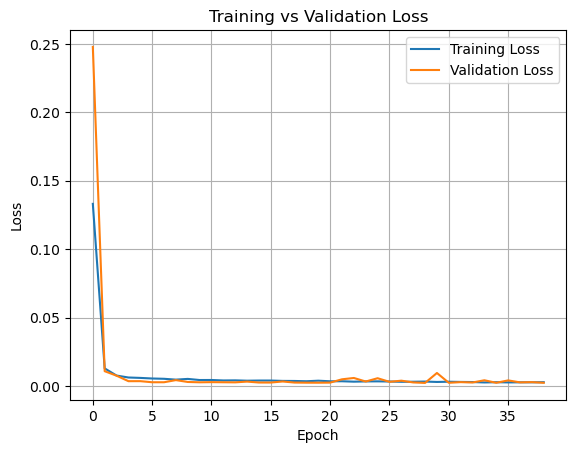

In [11]:
plt.plot(model_sp500_fit.history['loss'], label='Training Loss')
plt.plot(model_sp500_fit.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

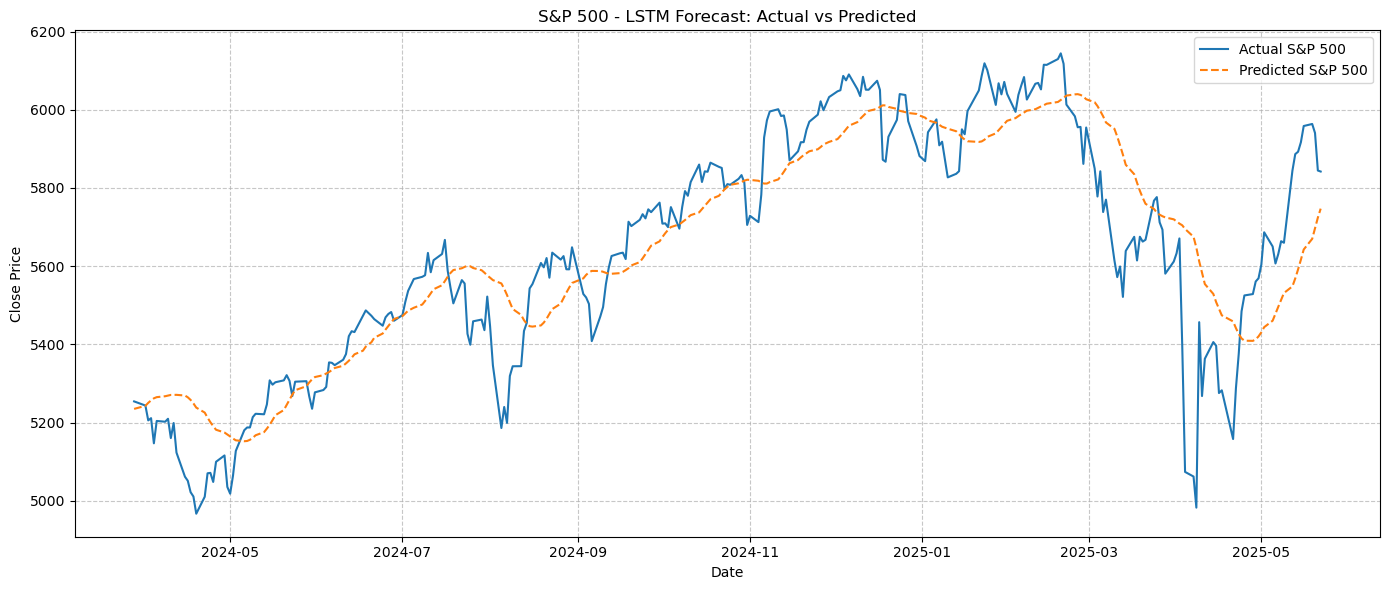

In [12]:
# Reconstruct the actual test values aligned with the predictions

# Inverse transform the predictions back to original scale
prediction_sp500_unscaled = scaler.inverse_transform(prediction_sp500)
actual_sp500_unscaled = scaler.inverse_transform(sp500_test_scaled[time_steps:])  # Original scaled test values

# Build a dataframe for comparison
results_sp500 = pd.DataFrame({
    'Date': sp500_test.iloc[time_steps:].index,
    'Actual': actual_sp500_unscaled.flatten(),
    'Predicted': prediction_sp500_unscaled.flatten()
})
results_sp500.set_index('Date', inplace=True)



# Plot the actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(results_sp500['Actual'], label='Actual S&P 500')
plt.plot(results_sp500['Predicted'], label='Predicted S&P 500', linestyle='--')
plt.title('S&P 500 - LSTM Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.grid(which='major', axis='both', linestyle='--', alpha=0.7)

plt.show()

S&P 500 - RMSE: 20501.75, MAE: 108.03, MAPE: 0.02%
Z-Score for S&P 500 predictions:


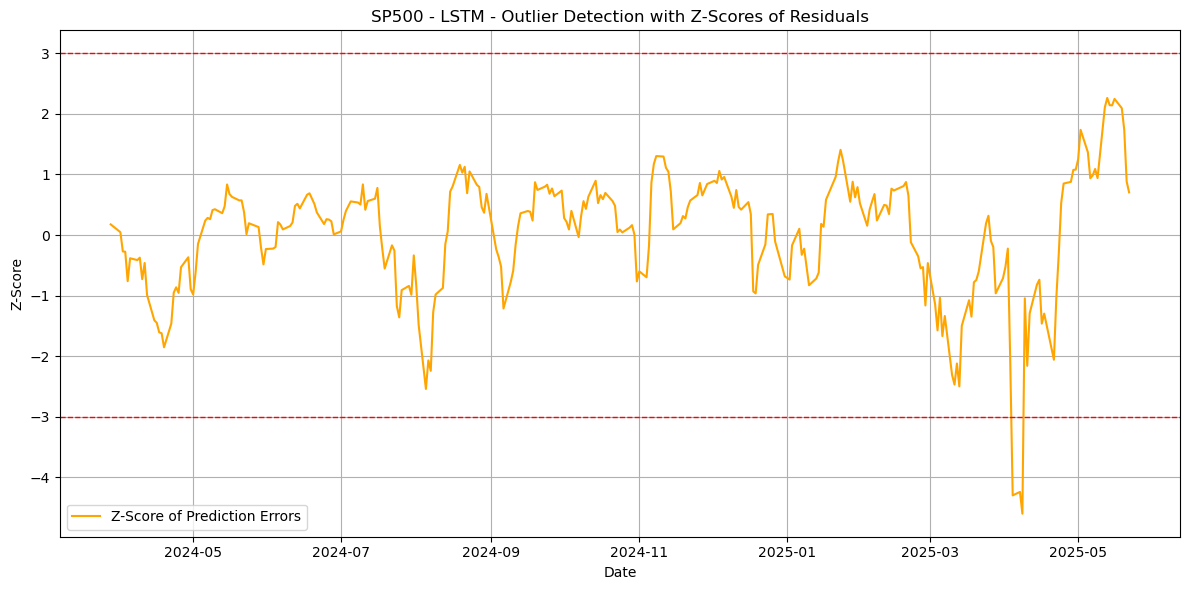

In [13]:
rmse_sp500 = mean_squared_error(results_sp500['Actual'], results_sp500['Predicted'])
mae_sp500 = mean_absolute_error(results_sp500['Actual'], results_sp500['Predicted'])
mape_sp500 = mean_absolute_percentage_error(results_sp500['Actual'], results_sp500['Predicted'])
print(f"S&P 500 - RMSE: {rmse_sp500:.2f}, MAE: {mae_sp500:.2f}, MAPE: {mape_sp500:.2f}%")

#z-score calculation
zscore_sp500 = zscore(results_sp500['Actual'] - results_sp500['Predicted']) 
print("Z-Score for S&P 500 predictions:")

plt.figure(figsize=(12, 6))
plt.plot(results_sp500.index, zscore_sp500, label='Z-Score of Prediction Errors', color='orange')
plt.axhline(3, color='red', linestyle='--', linewidth=1)
plt.axhline(-3, color='red', linestyle='--', linewidth=1)
plt.title('SP500 - LSTM - Outlier Detection with Z-Scores of Residuals')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [15]:
#LSTM model - Tesla

# Normalize the data
tesla_test_scaled = scaler.fit_transform(tesla_test)
tesla_train_scaled = scaler.transform(tesla_train)

time_steps_tesla = 60  # Number of time steps to look back
train_generator_tesla = TimeseriesGenerator(tesla_train_scaled, tesla_train_scaled, length=time_steps_tesla, batch_size=32)
test_generator_tesla = TimeseriesGenerator(tesla_test_scaled, tesla_test_scaled, length=time_steps_tesla, batch_size=32)

# Building the LSTM model for Tesla
model_tesla = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps_tesla, 1)),
    Dropout(0.5),
    LSTM(64, return_sequences = False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1),
])
Optimizer_tesla = Adam(learning_rate=0.00005)
model_tesla.compile(optimizer = Optimizer_tesla, loss='mean_squared_error')

model_tesla.summary()
checkpoint_tesla = ModelCheckpoint('best_model_tesla.keras', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 2)


# Fit the model
model_tesla_fit = model_tesla.fit(train_generator_tesla, epochs=20, validation_data=train_generator_tesla, callbacks=[early_stopping, checkpoint_tesla])

prediction_tesla = model_tesla.predict(test_generator_tesla)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1069
Epoch 1: val_loss improved from inf to 0.06382, saving model to best_model_tesla.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.1068 - val_loss: 0.0638
Epoch 2/20
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0506
Epoch 2: val_loss improved from 0.06382 to 0.01367, saving model to best_model_tesla.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0502 - val_loss: 0.0137
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0109
Epoch 3: val_loss improved from 0.01367 to 0.00370, saving model to best_model_tesla.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0109 - val_loss: 0.0037
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0052
Epoch 4: val_loss improved from 0.00370 to 0.00362, saving model to best_model_tesla.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0064
Epoch 5: val_l

Text(0.5, 0, 'Date')

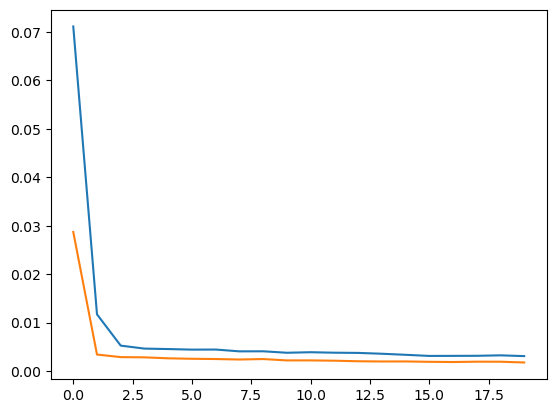

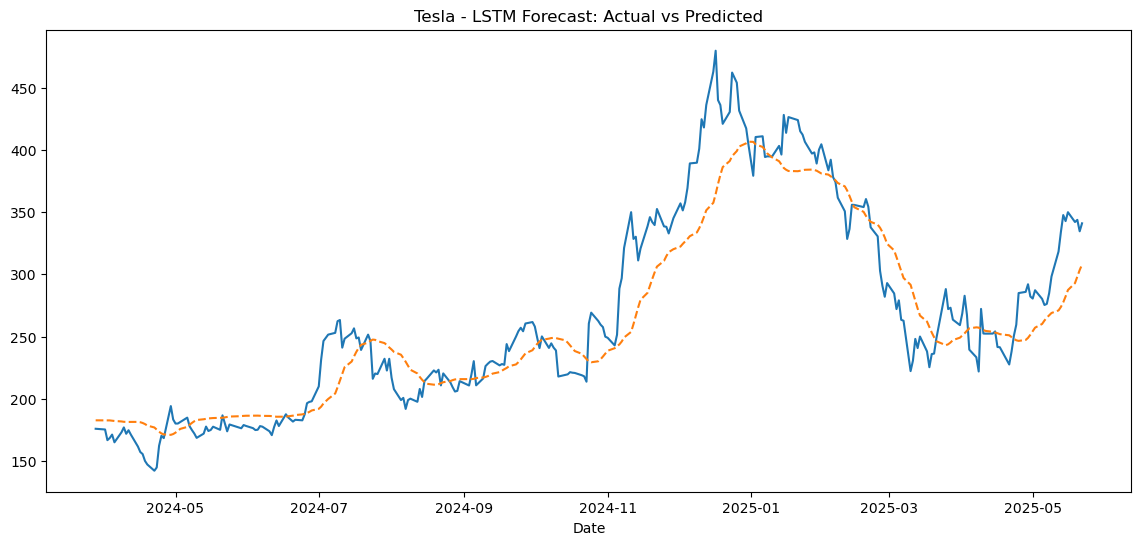

In [8]:
plt.plot(model_tesla_fit.history['loss'], label='Training Loss')
plt.plot(model_tesla_fit.history['val_loss'], label='Validation Loss')

prediction_tesla_unscaled = scaler.inverse_transform(prediction_tesla)
tesla_test_unscaled = scaler.inverse_transform(tesla_test_scaled[time_steps_tesla:])

result_tesla = pd.DataFrame({
    'Date': tesla_test.iloc[time_steps_tesla:].index,
    'Actual TSLA': tesla_test_unscaled.flatten(),
    'Predicted': prediction_tesla_unscaled.flatten()
})
result_tesla.set_index('Date', inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(result_tesla['Actual TSLA'], label='Actual TSLA')
plt.plot(result_tesla['Predicted'], label = 'Predicted TSLA', linestyle='--')
plt.title('Tesla - LSTM Forecast: Actual vs Predicted')
plt.xlabel('Date')


Tesla - Mean Absolute Error: 22.561871063338018
Tesla - Mean Absolute Percentage Error: 0.08200544036958128
Tesla - Mean Squared Error: 897.7980958501421


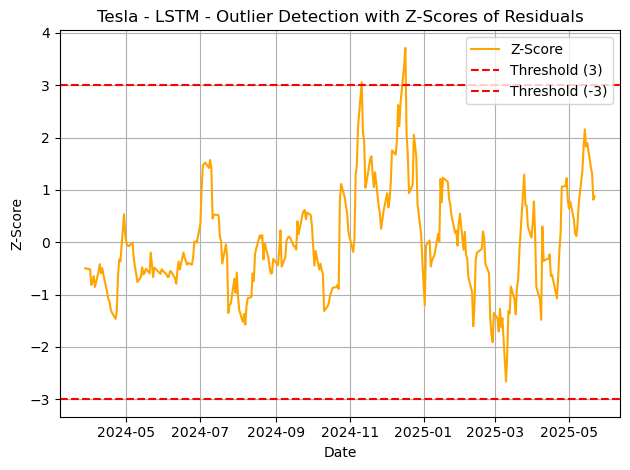

In [9]:
# Calculate and print evaluation metrics for S&P 500
mae_tesla = mean_absolute_error(result_tesla['Actual TSLA'], result_tesla['Predicted'])
mape_tesla = mean_absolute_percentage_error(result_tesla['Actual TSLA'], result_tesla['Predicted'])
mse_tesla = mean_squared_error(result_tesla['Actual TSLA'], result_tesla['Predicted'])

print(f'Tesla - Mean Absolute Error: {mae_tesla}')
print(f'Tesla - Mean Absolute Percentage Error: {mape_tesla}')
print(f'Tesla - Mean Squared Error: {mse_tesla}')

# Calulate the z-score
result_tesla['Z-Score'] = zscore(result_tesla['Actual TSLA'] - result_tesla['Predicted']) 
plt.plot(result_tesla['Z-Score'], label='Z-Score', color='orange')
plt.title('Tesla - LSTM - Outlier Detection with Z-Scores of Residuals')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.axhline(y=3, color='r', linestyle='--', label='Threshold (3)')
plt.axhline(y=-3, color='r', linestyle='--', label='Threshold (-3)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

